In [1]:
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import time

import matplotlib.pyplot as plt

import my_package
from my_package.core.AC_v4 import AC_agent

/home/paolo/.local/lib/python3.6/site-packages/gymnasium/core.py:27: UserWarning: WARN: Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env_name = 'ShipUniCont-v2'
env_options = {
    'generate_random_ship':             True,
    'workspace_safe_distance':          5,
    'ship_scale_factor':                2.0,
    'segments_lenght':                  0.25,
    'frame_per_step':                   30, # 1Hz
    'init_pose':                        None,
    'agent_radius':                     1.0,     # Ho aumentato l' agent radius in training
    'v_surge_max':                      0.1,
    'yaw_rel_max':                      np.pi/4,
    'lidar_params':                     {'n_beams': 10, 'max_range': 5.0, 'FoV': np.pi/2},
    'draw_lidar':                       True,
    'max_steps':                        2000
}

""" Init env """
env = gym.make(env_name, Options=env_options, workspace=(0,0,20,20))
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

max_episodes = 500
data_window = 10

buffer_params       = {'buffer_size': 1000000, 'batch_size': 256}
AC_params           = {'learn_every': 16, 'n_learn': 8, 'gamma': 0.99, 'tau': 1e-3, 'lr_actor': 1e-4, 'lr_critic': 1e-4}
noise_type          = 'param'
noise_params        = {'desired_std': 0.5, 'scalar': 0.05, 'scalar_decay': 0.99, 'min_std': 0.01, 'decay_with_ep': True}

""" Init AC agent """
agent = AC_agent(
    state_size=state_dim,
    action_size=action_dim,
    max_episodes=max_episodes,
    device=device,
    noise_params=noise_params,
    noise_type=noise_type,
    AC_params=AC_params,
    buffer_params=buffer_params
)

""" Data collect variables """
total_rewards = np.zeros(max_episodes)
noise_history = np.zeros(max_episodes)
len_episodes = np.zeros(max_episodes)
coverage_per_ep = np.zeros(max_episodes)

cuda


/home/paolo/miniconda3/envs/zenoenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
  return f(*args, **kwds)


In [3]:
start_time = time.time()

for episode in range(max_episodes):
    state, info = env.reset()
    agent.reset(episode)
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.step(state, action, reward, next_state, terminated)

        total_rewards[episode] += reward
        len_episodes[episode] += 1
        state = next_state
        done = terminated or truncated

    coverage_per_ep[episode] = info['coverage']
    if episode % data_window == 0 and episode != 0:
        ma_reward = np.mean(total_rewards[episode-data_window:episode])
        ma_coverage = np.mean(coverage_per_ep[episode-data_window:episode])
        print(f"Ep {episode}/{max_episodes}, MA Reward: {ma_reward:.2f}, MA Coverage: {ma_coverage:.1f} %")

env.close()

total_time_seconds = time.time() - start_time
hours = int(total_time_seconds // 3600)
minutes = int((total_time_seconds % 3600) // 60)
seconds = int(total_time_seconds % 60)
print(f"Training finito in: {hours} ore {minutes} minuti e {seconds} secondi")

Ep 10/500, MA Reward: -15.82, MA Coverage: 23.7 %
Ep 20/500, MA Reward: -21.12, MA Coverage: 16.7 %
Ep 30/500, MA Reward: -23.15, MA Coverage: 9.6 %
Ep 40/500, MA Reward: -9.51, MA Coverage: 32.6 %
Ep 50/500, MA Reward: -13.42, MA Coverage: 32.6 %
Ep 60/500, MA Reward: -18.66, MA Coverage: 18.3 %
Ep 70/500, MA Reward: -12.17, MA Coverage: 34.3 %
Ep 80/500, MA Reward: -1.51, MA Coverage: 52.0 %
Ep 90/500, MA Reward: 4.25, MA Coverage: 60.7 %
Ep 100/500, MA Reward: 24.53, MA Coverage: 71.7 %
Ep 110/500, MA Reward: 52.25, MA Coverage: 75.4 %
Ep 120/500, MA Reward: 77.47, MA Coverage: 80.7 %
Ep 130/500, MA Reward: 37.34, MA Coverage: 68.5 %
Ep 140/500, MA Reward: 40.84, MA Coverage: 78.3 %
Ep 150/500, MA Reward: 54.97, MA Coverage: 87.2 %
Ep 160/500, MA Reward: 16.38, MA Coverage: 71.5 %
Ep 170/500, MA Reward: 14.18, MA Coverage: 75.2 %
Ep 180/500, MA Reward: 34.76, MA Coverage: 71.3 %
Ep 190/500, MA Reward: 70.97, MA Coverage: 91.7 %
Ep 200/500, MA Reward: 25.76, MA Coverage: 75.2 %
Ep 21

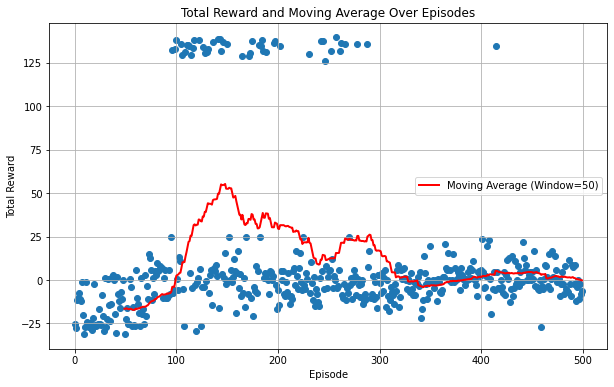

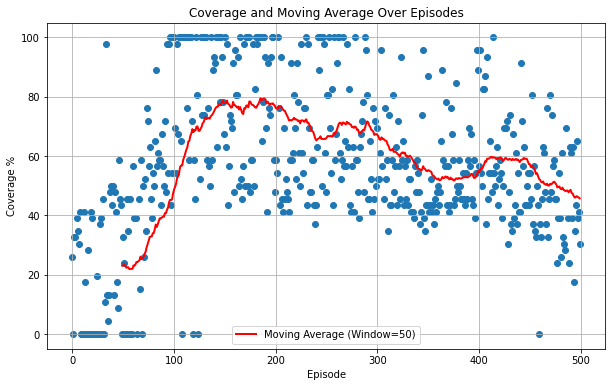

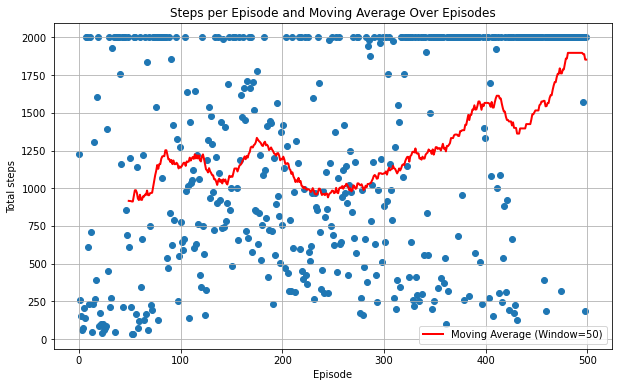

In [4]:
""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()


""" Plot coverage """
ma_coverage = np.convolve(coverage_per_ep, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(coverage_per_ep)), coverage_per_ep)
plt.plot(np.arange(window_size - 1, len(coverage_per_ep)), ma_coverage, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Coverage and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Coverage %')
plt.legend()
plt.grid(True)
plt.show()

""" Plot episode duration """
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, max_episodes), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Steps per Episode and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
trained_env_options = env_options
# trained_env_options['agent_radius'] = 0.5
yaws = []
v_surges = []
v_sways = []

env = gym.make(env_name, Options=trained_env_options, render_mode='human', workspace=(0,0,20,20))

for ep in range(3):
    state, info = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = agent.act(state, add_noise=False)
        next_state, reward, terminated, truncated, info = env.step(action)
        v_surges.append(action[0])
        yaws.append(action[1])
        done = terminated or truncated
        state = next_state
        total_reward += reward
        v_surge = env.agent.get_state()[3]
        if v_surge < 0:
            print(v_surge)
    if info['collision']:
        ending_cause = "collision"
    elif info['out_of_bounds']:
        ending_cause = "out of bounds"
    elif info['time_limit']:
        ending_cause = "max steps reached"
    elif info['coverage'] == 100:
        ending_cause = "100% coverage"
    else:
        ending_cause = "unkown"
    print('total reward: ' + str(total_reward) + ' end episode for: ' + ending_cause)
env.close()

-0.005863217090023199
-0.02676295502776108
-0.04302264651007853
-0.0556722840693499
-0.021110767936704522
-0.001644050899412984
-0.023480505229762704
-0.04046894841201398
-0.0536857095853449
-0.0637792665397688
-0.027417882131832765
-0.001434853281290761
-0.023317752532114707
-0.04034232918551675
-0.05358720167272379
-0.06151889472868795
-0.02565934580984672
-0.0007785082210911914
-0.022807125642123033
-0.03994506890796807
-0.053278138967231284
-0.05586171454004269
-0.021258142081777093
-1.8687453469605378e-05
-0.022215996160012318
-0.03948517878715146
-0.05292035115656492
-0.060202314821318395
-0.02463506583229767
-0.0006088706695802371
-0.0226751500996736
-0.03984239385960948
-0.05319825927619324
-0.054133057541285404
-0.019913272133537704
-0.010082270114943302
-0.030045316784502046
-0.04557627611332811
-0.05765913609288557
-0.02269565071377099
-0.008759810528692286
-0.029016462502485043
-0.044775842478433046
-0.057036410392006624
-0.022173726875865024
-0.006257247424430497
-0.027069

-0.016319386363935855
-0.03017191354583497
-0.001883262924031875
-0.023647961937060567
-0.01654888016192483
-0.029834087583073522
-0.001623744877496509
-0.023448027118224624
-0.01680734391210931
-0.02943782648236217
-0.0013354864904590634
-0.023225741996565387
-0.01721900854046234
-0.028901654628359353
-0.0009502999531112553
-0.022927573118495585
-0.017694942818714397
-0.028147346614472636
-0.00044877046170480983
-0.022538822305855948
-0.018273766599116174
-0.027188827560493393
-0.02206739450330201


KeyboardInterrupt: 

In [13]:
action_dim

2

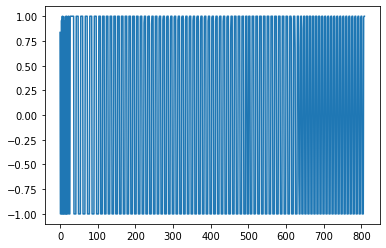

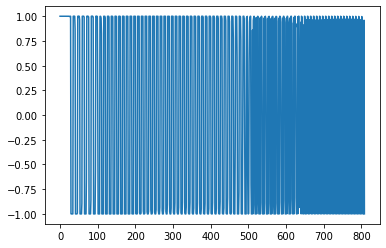

In [14]:
plt.plot(yaws)
plt.show()
plt.plot(v_surges)
plt.show()

In [ ]:
checkpoint = {
    'state_dim': state_dim,
    'action_dim': action_dim,
    'max_episodes' : max_episodes,
    'buffer_params': buffer_params,
    'noise_type': noise_type,
    'noise_params': noise_params,
    'AC_params': AC_params,
    'actor_state_dict': agent.actor.state_dict(),
    'total_rewards': total_rewards,
    'len_episodes' : len_episodes,
    'coverage_per_ep': coverage_per_ep,
    'env_options' : env_options,
    'trained_env_options': trained_env_options,
    'env_name': env_name,
    'workspace': (0,0,20,20)
}

path = "Zeno/" + env_name + "_" + str(max_episodes) + "_ep_final" + ".pth"
torch.save(checkpoint, path)